# Local MLflow SQLite Exploration
Use this notebook to point at a transferred `mlflow.db`, extract runs, apply filters, and inspect metrics.

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Iterable, Mapping, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow
from mlflow.entities import Run
from mlflow.tracking import MlflowClient

DB_CANDIDATES: Sequence[Path] = (
    Path("../results/mlflow.db"),
    Path("../mlruns/mlflow.db"),
    Path("../mlflow.db"),
    Path("mlflow.db"),
 )

@dataclass
class RunFilters:
    experiment_names: Iterable[str] | None = None
    status: Iterable[str] | None = None
    start_after: datetime | None = None
    start_before: datetime | None = None
    tags: Mapping[str, str] | None = None
    params: Mapping[str, str] | None = None
    supervision_mode: str | None = None
    tag_algorithm_semi_supervised: str | None = None
    tag_algorithm_semi_supervised_ne: str | None = None
    parent_only: bool = False
    child_only: bool = False

def resolve_db_path(candidates: Sequence[Path]) -> Path:
    """Return the first existing SQLite path from the provided candidates."""
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(
        "No MLflow SQLite database found. Update DB_CANDIDATES with the correct path."
    )

MLFLOW_DB_PATH = resolve_db_path(DB_CANDIDATES)
BACKEND_STORE_URI = f"sqlite:///{MLFLOW_DB_PATH}"
mlflow.set_tracking_uri(BACKEND_STORE_URI)
CLIENT = MlflowClient(tracking_uri=BACKEND_STORE_URI)
MLFLOW_DB_PATH

2025/12/10 23:51:51 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/10 23:51:51 INFO mlflow.store.db.utils: Updating database tables
2025-12-10 23:51:51 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-12-10 23:51:51 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-12-10 23:51:51 INFO  [alembic.runtime.migration] Running upgrade bda7b8c39065 -> cbc13b556ace, add V3 trace schema columns
2025-12-10 23:51:51 INFO  [alembic.runtime.migration] Running upgrade cbc13b556ace -> 770bee3ae1dd, add assessments table
2025-12-10 23:51:51 INFO  [alembic.runtime.migration] Running upgrade 770bee3ae1dd -> a1b2c3d4e5f6, add spans table
2025-12-10 23:51:51 INFO  [alembic.runtime.migration] Running upgrade a1b2c3d4e5f6 -> de4033877273, create entity_associations table
2025-12-10 23:51:51 INFO  [alembic.runtime.migration] Running upgrade de4033877273 -> 1a0cddfcaa16, Add webhooks and webhook_events tables
2025-12-10 23:51:51 INFO  [ale

PosixPath('/home/ladmin/tsseg-project/tsseg-exp/results/mlflow.db')

In [2]:
def _experiment_ids_from_names(names: Iterable[str] | None) -> list[str]:
    if not names:
        return [exp.experiment_id for exp in CLIENT.search_experiments()]
    experiments = {exp.name: exp.experiment_id for exp in CLIENT.search_experiments()}
    missing = [name for name in names if name not in experiments]
    if missing:
        raise KeyError(
            f"Experiments not found in backend: {missing}. Available: {sorted(experiments)}"
        )
    return [experiments[name] for name in names]

def _build_filter_string(filters: RunFilters) -> str:
    clauses: list[str] = []
    # MLflow filter syntax does not support NULL comparisons on tags, so parent/child
    # filtering is performed after the search query completes.
    if filters.status:
        statuses = list(filters.status)
        if len(statuses) == 1:
            clauses.append(f"attributes.status = '{statuses[0].upper()}'")
        else:
            status_clause = " or ".join(
                f"attributes.status = '{status.upper()}'" for status in statuses
            )
            clauses.append(f"({status_clause})")
    if filters.start_after:
        millis = int(filters.start_after.timestamp() * 1000)
        clauses.append(f"attributes.start_time >= {millis}")
    if filters.start_before:
        millis = int(filters.start_before.timestamp() * 1000)
        clauses.append(f"attributes.start_time <= {millis}")
    if filters.tags:
        for key, value in filters.tags.items():
            clauses.append(f"tags.{key} = '{value}'")
    if filters.params:
        for key, value in filters.params.items():
            clauses.append(f"params.{key} = '{value}'")
    # Convenience: allow explicit supervision_mode on RunFilters (maps to param supervision_mode)
    if getattr(filters, "supervision_mode", None):
        clauses.append(f"params.supervision_mode = '{filters.supervision_mode}'")
    # Convenience: allow explicit tag_algorithm_semi_supervised on RunFilters
    if getattr(filters, "tag_algorithm_semi_supervised", None):
        clauses.append(f"tags.algorithm_semi_supervised = '{filters.tag_algorithm_semi_supervised}'")
    # Convenience: allow explicit tag_algorithm_semi_supervised_ne on RunFilters
    if getattr(filters, "tag_algorithm_semi_supervised_ne", None):
        clauses.append(f"tags.algorithm_semi_supervised != '{filters.tag_algorithm_semi_supervised_ne}'")
    return " and ".join(clauses)

def search_runs(filters: RunFilters | None = None, max_results: int = 50000) -> list[Run]:
    filters = filters or RunFilters()
    if filters.parent_only and filters.child_only:
        raise ValueError("Cannot request both parent and child runs simultaneously.")
    experiment_ids = _experiment_ids_from_names(filters.experiment_names)
    filter_string = _build_filter_string(filters)
    paged_runs = CLIENT.search_runs(
        experiment_ids=experiment_ids,
        filter_string=filter_string,
        run_view_type=mlflow.entities.ViewType.ALL,
        max_results=max_results,
        order_by=["attributes.start_time DESC"],
    )
    runs = list(paged_runs)
    if filters.parent_only:
        runs = [run for run in runs if not run.data.tags.get("mlflow.parentRunId")] 
    if filters.child_only:
        runs = [run for run in runs if run.data.tags.get("mlflow.parentRunId")] 
    return runs

In [3]:
def runs_to_frame(runs: Sequence[Run]) -> pd.DataFrame:
    if not runs:
        return pd.DataFrame()
    records: list[dict] = []
    for run in runs:
        info = run.info
        data = run.data
        row: dict[str, object] = {
            "run_id": info.run_id,
            "experiment_id": info.experiment_id,
            "name": data.tags.get("mlflow.runName", info.run_id),
            "status": info.status,
            "start_time": pd.to_datetime(info.start_time, unit="ms"),
            "end_time": (
                pd.to_datetime(info.end_time, unit="ms") if info.end_time else pd.NaT
            ),
            "lifecycle_stage": info.lifecycle_stage,
            "artifact_uri": info.artifact_uri,
            "parent_run_id": data.tags.get("mlflow.parentRunId"),
            "dataset_name": data.tags.get("dataset_name"),
            "algorithm_name": data.params.get("algorithm_name") or data.tags.get("algorithm_name"),
            "pipeline": data.params.get("pipeline") or data.tags.get("pipeline"),
            "supervision_mode": data.params.get("supervision_mode"),
        }
        row.update({f"param_{key}": value for key, value in data.params.items()})
        row.update({f"metric_{key}": value for key, value in data.metrics.items()})
        row.update({f"tag_{key}": value for key, value in data.tags.items()})
        records.append(row)
    df = pd.DataFrame.from_records(records)
    if not df.empty:
        df.sort_values("start_time", ascending=False, inplace=True)
        df.reset_index(drop=True, inplace=True)
    return df

In [4]:
def filter_metric_table(df: pd.DataFrame, metric_key: str) -> pd.DataFrame:
    column = f"metric_{metric_key}"
    if column not in df.columns:
        raise KeyError(
            f"Metric '{metric_key}' not present. Available metrics: {sorted(c[7:] for c in df.columns if c.startswith('metric_'))}"
        )
    subset = df[["run_id", "name", "status", column, "start_time", "dataset_name", "tag_algorithm_task", "supervision_mode"]].copy()
    subset.rename(columns={column: metric_key}, inplace=True)
    return subset

def list_run_artifacts(run_id: str, path: str | None = None) -> pd.DataFrame:
    artifacts = CLIENT.list_artifacts(run_id, path or "")
    rows = []
    for item in artifacts:
        rows.append(
            {
                "path": item.path,
                "is_dir": item.is_dir,
                "file_size": getattr(item, "file_size", None),
            }
        )
    return pd.DataFrame(rows)

In [ ]:
# Unsupervised filters
unsupervised_filters = RunFilters(
    experiment_names=["tsseg-experiment-unsupervised-6-12"],
    status=["FINISHED"],
    start_after=datetime(2025, 11, 23),
    child_only=True,
    #supervision_mode="unsupervised",
    #tag_algorithm_semi_supervised_ne="True"
)

# Supervised filters
supervised_filters = RunFilters(
    experiment_names=["tsseg-experiment-supervised-6-12"],
    status=["FINISHED"],
    start_after=datetime(2025, 11, 23),
    child_only=True,
    #supervision_mode="semi_supervised"
    # tag_algorithm_semi_supervised is ignored
)

unsupervised_runs = search_runs(unsupervised_filters)
unsupervised_df = runs_to_frame(unsupervised_runs)

supervised_runs = search_runs(supervised_filters)
supervised_df = runs_to_frame(supervised_runs)

# Concatenate for compatibility with other cells
runs_df = pd.concat([unsupervised_df, supervised_df], ignore_index=True)

print(f"Unsupervised runs: {len(unsupervised_df)}")
print(f"Supervised runs: {len(supervised_df)}")
print(f"Total runs: {len(runs_df)}")
runs_df.head()

Unsupervised runs: 180
Supervised runs: 234
Total runs: 414


,run_id,experiment_id,name,status,start_time,end_time,lifecycle_stage,artifact_uri,parent_run_id,dataset_name,...,param_trial_supervision_change_points,param_trial_supervision_states,param_trial_supervision_override_n_states,param_trial_supervision_override_n_changepoints,param_trial_supervision_override_n_segments,param_trial_supervision_override_n_cps,param_trial_supervision_override_n_max_states,param_trial_supervision_override_k_max,param_trial_supervision_override_alphabet_size,param_trial_supervision_override_n_change_points
0,0fa05df0d83f4d8081b3b213424027cc,6,bocd_mocap_unsupervised_9,FINISHED,2025-12-08 08:41:19.696,2025-12-08 09:21:37.586,active,/scratch/fchavell/tsseg-exp/mlartifacts/6/0fa0...,2c37a8a9bc7a4302a25475284082d908,mocap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b15d1c6b0b204092b0f1d2215441950b,6,bocd_mocap_unsupervised_8,FINISHED,2025-12-08 08:06:31.979,2025-12-08 08:41:19.647,active,/scratch/fchavell/tsseg-exp/mlartifacts/6/b15d...,2c37a8a9bc7a4302a25475284082d908,mocap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bce2c51f3d974eb19c244d968c5b8c23,6,bocd_mocap_unsupervised_7,FINISHED,2025-12-08 06:59:38.953,2025-12-08 08:06:31.933,active,/scratch/fchavell/tsseg-exp/mlartifacts/6/bce2...,2c37a8a9bc7a4302a25475284082d908,mocap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8b55307d62684319bee2cbd10696d717,6,bocd_mocap_unsupervised_6,FINISHED,2025-12-08 06:35:24.115,2025-12-08 06:59:38.904,active,/scratch/fchavell/tsseg-exp/mlartifacts/6/8b55...,2c37a8a9bc7a4302a25475284082d908,mocap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,237abfcad23940c5931c44ffafb1af5d,6,bocd_mocap_unsupervised_5,FINISHED,2025-12-08 04:53:39.313,2025-12-08 06:35:24.053,active,/scratch/fchavell/tsseg-exp/mlartifacts/6/237a...,2c37a8a9bc7a4302a25475284082d908,mocap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
runs_df.columns.tolist()

['run_id',
 'experiment_id',
 'name',
 'status',
 'start_time',
 'end_time',
 'lifecycle_stage',
 'artifact_uri',
 'parent_run_id',
 'dataset_name',
 'algorithm_name',
 'pipeline',
 'supervision_mode',
 'param_algorithm_name',
 'param_modality',
 'param_supervision_mode',
 'param_algorithm_semi_supervised',
 'metric_f1_score_score',
 'metric_f1_score_precision',
 'metric_f1_score_recall',
 'metric_gaussian_f1_score',
 'metric_gaussian_f1_precision',
 'metric_gaussian_f1_recall',
 'metric_gaussian_f1_matched_weight',
 'metric_covering_score',
 'metric_covering_covering',
 'metric_bidirectional_covering_score',
 'metric_bidirectional_covering_ground_truth_covering',
 'metric_bidirectional_covering_prediction_covering',
 'metric_execution_time_seconds',
 'tag_mlflow.user',
 'tag_mlflow.source.name',
 'tag_mlflow.source.type',
 'tag_mlflow.parentRunId',
 'tag_mlflow.runName',
 'tag_algorithm_name',
 'tag_modality',
 'tag_dataset_name',
 'tag_dataset_trial_index',
 'tag_algorithm_task',
 't

In [36]:
unsupervised_df[unsupervised_df["algorithm_name"] == "autoplait"]["tag_algorithm_semi_supervised"].unique()

array(['True'], dtype=object)

In [34]:
unsupervised_df[unsupervised_df["algorithm_name"] == "autoplait"].columns.tolist()

['run_id',
 'experiment_id',
 'name',
 'status',
 'start_time',
 'end_time',
 'lifecycle_stage',
 'artifact_uri',
 'parent_run_id',
 'dataset_name',
 'algorithm_name',
 'pipeline',
 'supervision_mode',
 'param_algorithm_name',
 'param_modality',
 'param_supervision_mode',
 'param_algorithm_semi_supervised',
 'metric_f1_score_score',
 'metric_f1_score_precision',
 'metric_f1_score_recall',
 'metric_gaussian_f1_score',
 'metric_gaussian_f1_precision',
 'metric_gaussian_f1_recall',
 'metric_gaussian_f1_matched_weight',
 'metric_covering_score',
 'metric_covering_covering',
 'metric_bidirectional_covering_score',
 'metric_bidirectional_covering_ground_truth_covering',
 'metric_bidirectional_covering_prediction_covering',
 'metric_execution_time_seconds',
 'tag_mlflow.user',
 'tag_mlflow.source.name',
 'tag_mlflow.source.type',
 'tag_mlflow.parentRunId',
 'tag_mlflow.runName',
 'tag_algorithm_name',
 'tag_modality',
 'tag_dataset_name',
 'tag_dataset_trial_index',
 'tag_algorithm_task',
 't

In [18]:
def display_run_counts(df, title):
    if df.empty:
        print(f"{title}: No runs available.")
    else:
        # Create a summary table of run counts per algorithm and dataset
        run_counts_summary = pd.crosstab(
            df["algorithm_name"].fillna("Unknown"),
            df["dataset_name"].fillna("Unknown")
        )
        print(f"{title}: Run counts per Algorithm and Dataset")
        display(run_counts_summary)

display_run_counts(unsupervised_df, "Unsupervised")
display_run_counts(supervised_df, "Supervised")

Unsupervised: Run counts per Algorithm and Dataset


dataset_name,mocap
algorithm_name,
amoc,9
binseg,9
bocd,9
bottomup,9
clap,9
clasp,9
e2usd,9
eagglo,9
fluss,9


Supervised: Run counts per Algorithm and Dataset


dataset_name,mocap
algorithm_name,
amoc,9
autoplait,9
binseg,9
bocd,9
bottomup,9
clap,9
clasp,9
dynp,9
e2usd,9


In [50]:
def display_run_counts(df, title):
    if df.empty:
        print(f"{title}: No runs available.")
    else:
        # Create a summary table of run counts per algorithm and dataset
        run_counts_summary = pd.crosstab(
            df["algorithm_name"].fillna("Unknown"),
            df["dataset_name"].fillna("Unknown")
        )
        print(f"{title}: Run counts per Algorithm and Dataset")
        display(run_counts_summary)

display_run_counts(unsupervised_df, "Unsupervised")
display_run_counts(supervised_df, "Supervised")

Unsupervised: Run counts per Algorithm and Dataset


dataset_name,actrectut,has,mocap,skab,tssb,usc-had,utsa
algorithm_name,,,,,,,
amoc,2,250,9,34,75,70,32
binseg,2,250,9,34,75,70,32
bocd,0,8,9,34,15,0,5
bottomup,2,250,9,34,75,70,32
clap,0,250,9,34,75,70,32
clasp,2,250,9,34,0,70,32
e2usd,2,250,9,34,75,70,32
eagglo,0,8,9,34,15,0,28
espresso,2,231,9,34,75,18,32


Supervised: Run counts per Algorithm and Dataset


dataset_name,actrectut,has,mocap,skab,tssb,usc-had,utsa
algorithm_name,,,,,,,
amoc,2,250,9,34,75,70,32
autoplait,2,250,9,34,75,70,32
binseg,2,250,9,34,75,70,32
bocd,0,8,9,34,15,0,5
bottomup,2,250,9,34,75,70,32
clap,2,250,9,34,75,70,32
clasp,2,250,9,34,75,70,32
dynp,2,64,9,34,75,3,32
e2usd,2,250,9,34,75,70,32


## Visualizations
Use the helpers below to generate plots from the consolidated statistics once they have been inspected.

In [53]:
def plot_metric_boxplot(
    df: pd.DataFrame,
    metric_key: str,
    algo_column: str = "name",
    dataset_column: str = "dataset_name",
    title: str | None = None,
    show_points: bool = False,
) -> None:
    """Plot a metric distribution grouped by algorithm with dataset hue."""
    if df.empty:
        raise ValueError("No runs available to plot.")
    metric_col = f"metric_{metric_key}" if f"metric_{metric_key}" in df.columns else metric_key
    if metric_col not in df.columns:
        available = sorted(c[7:] for c in df.columns if c.startswith("metric_"))
        raise KeyError(f"Column '{metric_col}' not found. Available metric columns: {available}")
    plot_df = df[[algo_column, dataset_column, metric_col]].copy() if dataset_column in df.columns else df[[algo_column, metric_col]].copy()
    plot_df.rename(columns={algo_column: "algorithm", metric_col: metric_key}, inplace=True)
    if dataset_column in df.columns:
        plot_df.rename(columns={dataset_column: "dataset"}, inplace=True)
        plot_df["dataset"].fillna("Unknown dataset", inplace=True)
    else:
        plot_df["dataset"] = "Unknown dataset"
    plot_df.dropna(subset=[metric_key], inplace=True)
    if plot_df.empty:
        raise ValueError(f"No data available for metric '{metric_key}' after dropping NaNs.")
    plot_df["algorithm"] = plot_df["algorithm"].apply(lambda x: x.split("_")[0] if isinstance(x, str) and "_" in x else x).fillna("Unknown")
    order = plot_df.groupby("algorithm")[metric_key].median().sort_values(ascending=False).index.tolist()
    hue_order = sorted(plot_df["dataset"].unique())
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=plot_df, x="algorithm", y=metric_key, order=order, color="white", fliersize=0)
    if show_points:
        sns.stripplot(
            data=plot_df,
            x="algorithm",
            y=metric_key,
            hue="dataset",
            order=order,
            hue_order=hue_order,
            dodge=False,
            marker="o",
            size=5,
            alpha=0.7,
        )
    plt.title(title or f"{metric_key} distribution by algorithm")
    plt.xlabel("Algorithm")
    plt.ylabel(metric_key)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [58]:
def plot_runtime_log(
    df: pd.DataFrame,
    title: str | None = None,
    show_points: bool = False,
) -> None:
    """Plot mean execution time grouped by algorithm with dataset hue using log scale."""
    if df.empty:
        print(f"{title}: No runs available to plot.")
        return
    
    metric_key = "execution_time_seconds"
    metric_col = f"metric_{metric_key}" if f"metric_{metric_key}" in df.columns else metric_key
    
    if metric_col not in df.columns:
        print(f"Column '{metric_col}' not found.")
        return

    plot_df = df.copy()
    plot_df.rename(columns={metric_col: metric_key}, inplace=True)
    plot_df["dataset_name"] = plot_df["dataset_name"].fillna("Unknown dataset")
    plot_df.dropna(subset=[metric_key], inplace=True)
    
    if plot_df.empty:
        print(f"No data available for metric '{metric_key}' after dropping NaNs.")
        return

    plot_df["algorithm"] = plot_df["algorithm_name"].fillna("Unknown")
    
    # Aggregate: Mean per dataset per algorithm
    agg_df = plot_df.groupby(["algorithm", "dataset_name"], as_index=False)[metric_key].mean()

    # Sort by median of means
    order = agg_df.groupby("algorithm")[metric_key].median().sort_values(ascending=False).index.tolist()
    hue_order = sorted(agg_df["dataset_name"].unique())

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    # Boxplot
    sns.boxplot(
        data=agg_df,
        x="algorithm",
        y=metric_key,
        order=order,
        color="white",
        fliersize=0,
    )

    if show_points:
        sns.stripplot(
            data=agg_df,
            x="algorithm",
            y=metric_key,
            hue="dataset_name",
            order=order,
            hue_order=hue_order,
            dodge=False,
            marker="o",
            size=5,
            alpha=0.7,
        )
    
    plt.yscale("log")
    plt.title(title or "Mean Execution Time (Log Scale) by Algorithm")
    plt.xlabel("Algorithm")
    plt.ylabel("Mean Execution Time (seconds) - Log Scale")
    plt.xticks(rotation=45, ha="right")
    if show_points:
        plt.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_17800/2228269478.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df["dataset"].fillna("Unknown dataset", inplace=True)
/tmp/ipykernel_17800/2228269478.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left")


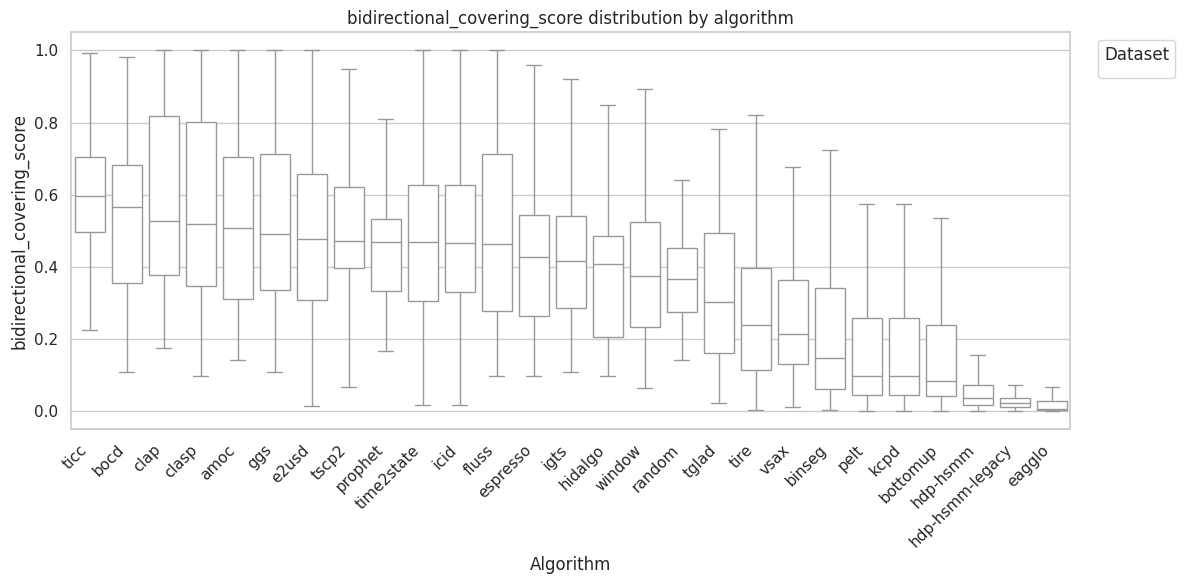

/tmp/ipykernel_17800/2228269478.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df["dataset"].fillna("Unknown dataset", inplace=True)
/tmp/ipykernel_17800/2228269478.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left")


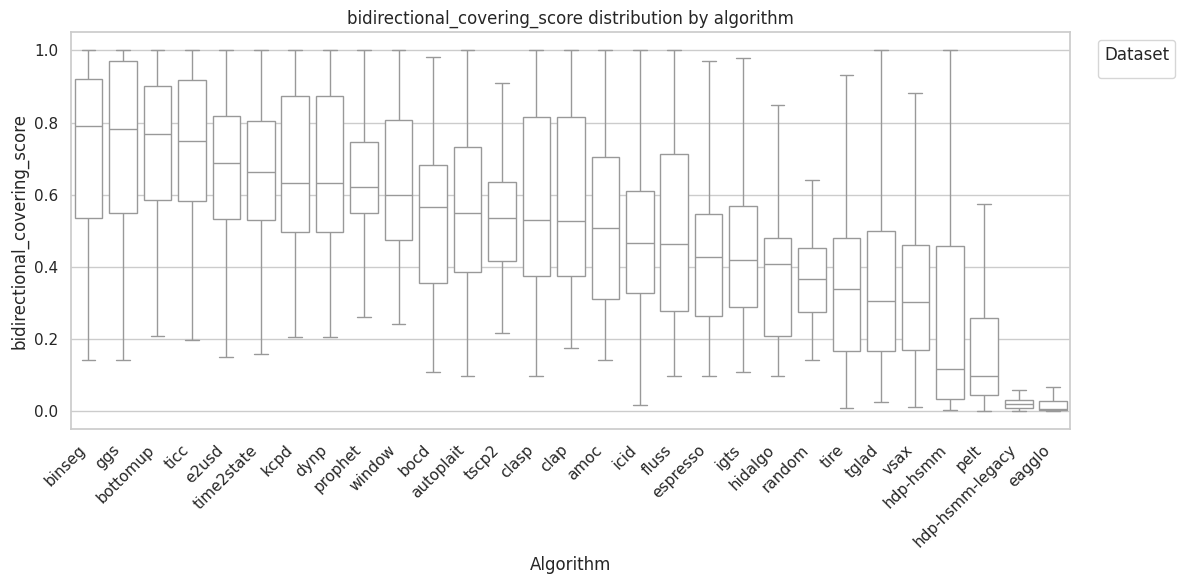

In [59]:
plot_metric_boxplot(unsupervised_df, metric_key="bidirectional_covering_score")
plot_metric_boxplot(supervised_df, metric_key="bidirectional_covering_score")

/tmp/ipykernel_17800/2228269478.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df["dataset"].fillna("Unknown dataset", inplace=True)
/tmp/ipykernel_17800/2228269478.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left")


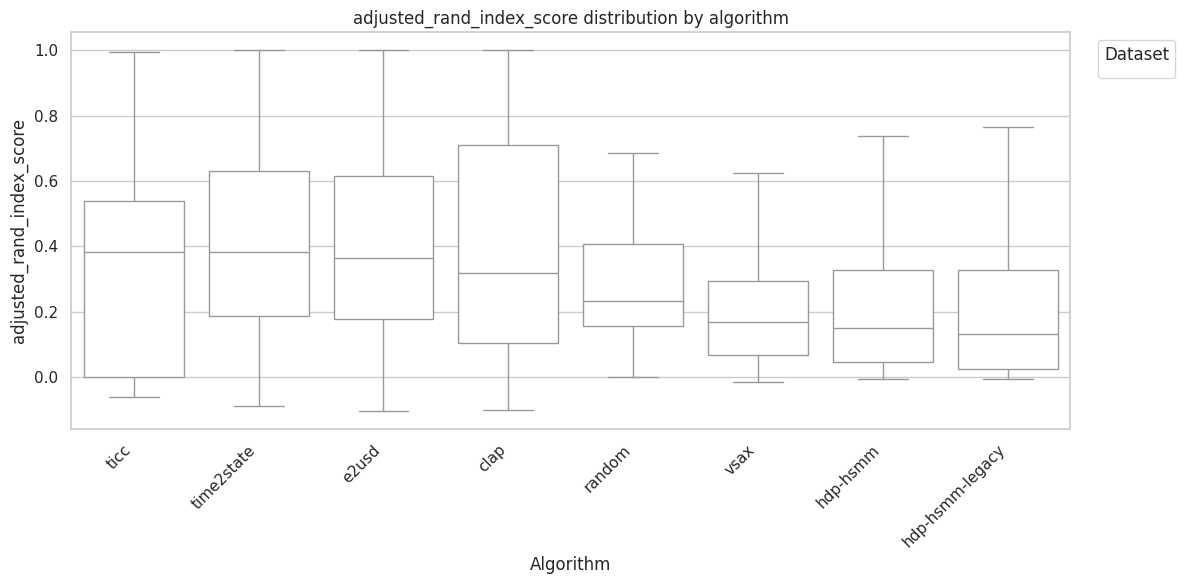

/tmp/ipykernel_17800/2228269478.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df["dataset"].fillna("Unknown dataset", inplace=True)
/tmp/ipykernel_17800/2228269478.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left")
/tmp/ipykernel_17800/2228269478.py:49: UserWarning: No artists with labels found to put in legend.  Note 

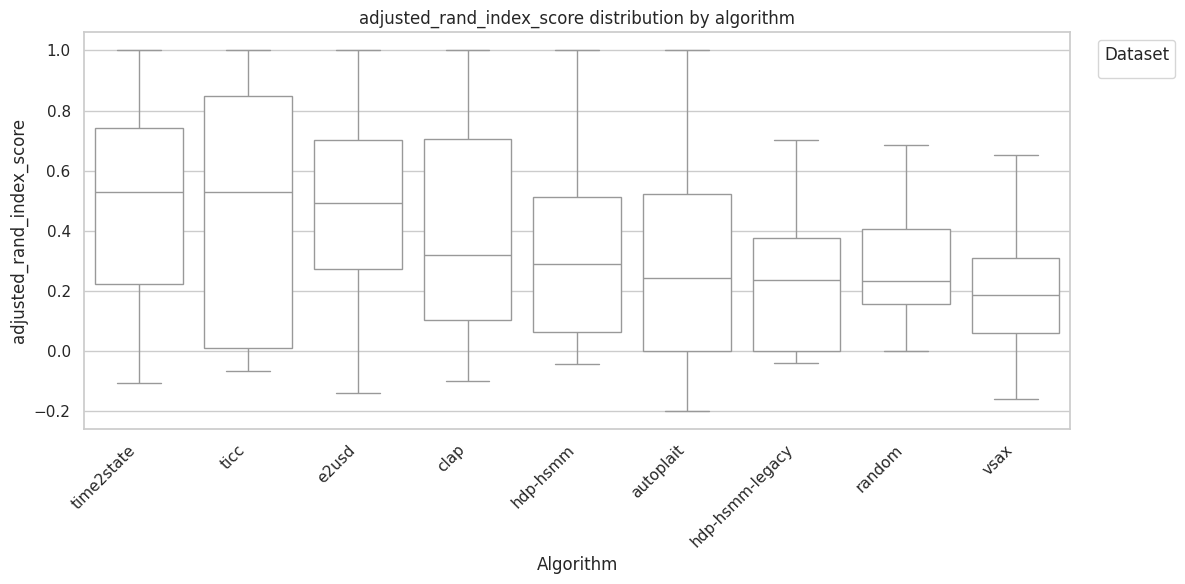

In [60]:
plot_metric_boxplot(unsupervised_df, metric_key="adjusted_rand_index_score")
plot_metric_boxplot(supervised_df, metric_key="adjusted_rand_index_score")

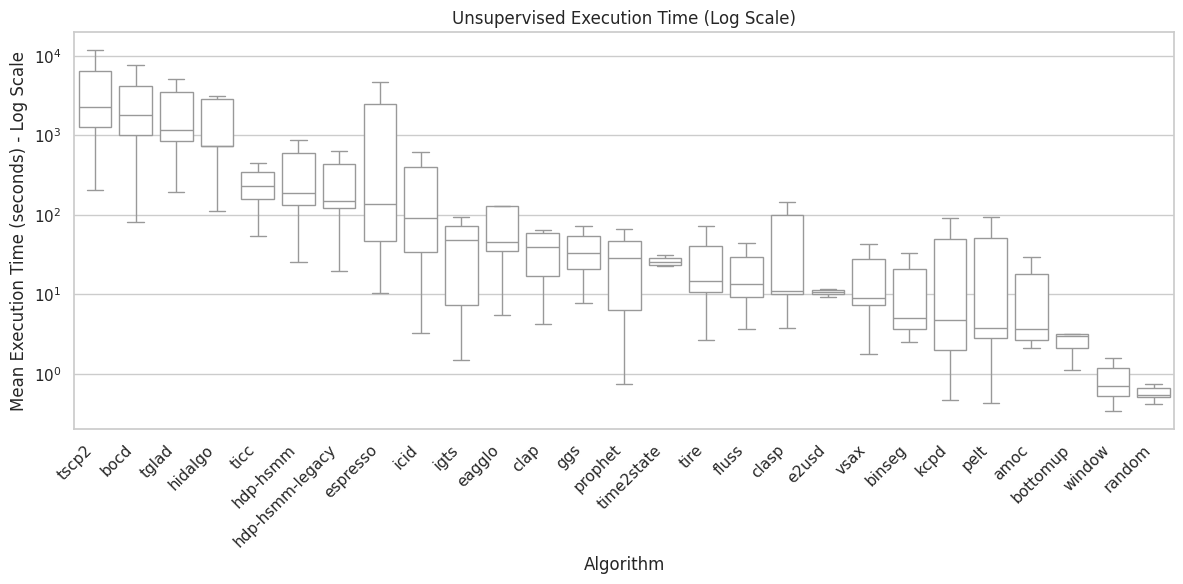

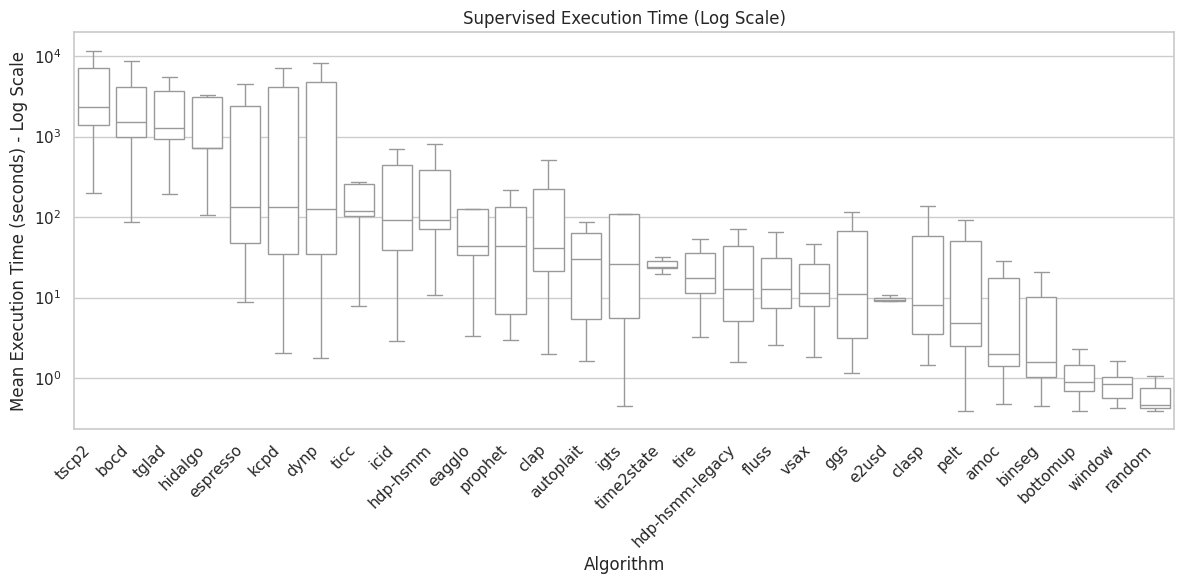

In [61]:
plot_runtime_log(unsupervised_df, title="Unsupervised Execution Time (Log Scale)")
plot_runtime_log(supervised_df, title="Supervised Execution Time (Log Scale)")